In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
data_dir = os.path.join(".", "orbit_training_runs", "scaling_laws_v2")

df_list = []
for f in os.listdir(data_dir):
    if not f.endswith(".csv"):
        continue
    df_list.append(pd.read_csv(os.path.join(data_dir, f)))

df = pd.concat(df_list, ignore_index=True)

In [29]:
df.head()

,run_name,min_val_loss,batch_size,coordinate_system,d_ff,d_model,dataset_size,epochs,input_length,learning_rate,n_bins,n_heads,n_layers,trade_name
0,learning_rate0.001_batch_size64_n_layers6_n_he...,3.960725,64,cartesian,2048,512,5000,10,32,0.00100,128,8,6,scaling_laws_v2
1,learning_rate1e-05_batch_size32_n_layers2_n_he...,8.253028,32,cartesian,512,128,100,10,32,0.00001,8192,2,2,scaling_laws_v2
2,learning_rate0.0001_batch_size16_n_layers4_n_h...,0.940606,16,spherical,1024,256,5000,10,32,0.00010,2048,4,4,scaling_laws_v2
3,learning_rate1e-05_batch_size32_n_layers2_n_he...,4.841044,32,cartesian,512,128,100,10,32,0.00001,512,2,2,scaling_laws_v2
4,learning_rate1e-05_batch_size32_n_layers4_n_he...,1.915608,32,spherical,1024,256,100,10,32,0.00001,128,4,4,scaling_laws_v2


In [30]:
def get_legend_label(row):
    if row['n_layers'] == 2:
        return "small"
    elif row['n_layers'] == 4:
        return "medium"
    elif row['n_layers'] == 6:
        return "large"
    else:
        return "unknown"

def get_unique_combinations(row):
    return (row['n_bins'], row['coordinate_system'])

def get_batch_times_lr(row):
    return row['batch_size'] * row['learning_rate']

In [31]:
df["legend_label"] = df.apply(get_legend_label, axis=1)
df["unique_combinations"] = df.apply(get_unique_combinations, axis=1)
df["batch_times_lr"] = df.apply(get_batch_times_lr, axis=1)
df.head()

,run_name,min_val_loss,batch_size,coordinate_system,d_ff,d_model,dataset_size,epochs,input_length,learning_rate,n_bins,n_heads,n_layers,trade_name,legend_label,unique_combinations,batch_times_lr
0,learning_rate0.001_batch_size64_n_layers6_n_he...,3.960725,64,cartesian,2048,512,5000,10,32,0.00100,128,8,6,scaling_laws_v2,large,"(128, cartesian)",0.06400
1,learning_rate1e-05_batch_size32_n_layers2_n_he...,8.253028,32,cartesian,512,128,100,10,32,0.00001,8192,2,2,scaling_laws_v2,small,"(8192, cartesian)",0.00032
2,learning_rate0.0001_batch_size16_n_layers4_n_h...,0.940606,16,spherical,1024,256,5000,10,32,0.00010,2048,4,4,scaling_laws_v2,medium,"(2048, spherical)",0.00160
3,learning_rate1e-05_batch_size32_n_layers2_n_he...,4.841044,32,cartesian,512,128,100,10,32,0.00001,512,2,2,scaling_laws_v2,small,"(512, cartesian)",0.00032
4,learning_rate1e-05_batch_size32_n_layers4_n_he...,1.915608,32,spherical,1024,256,100,10,32,0.00001,128,4,4,scaling_laws_v2,medium,"(128, spherical)",0.00032


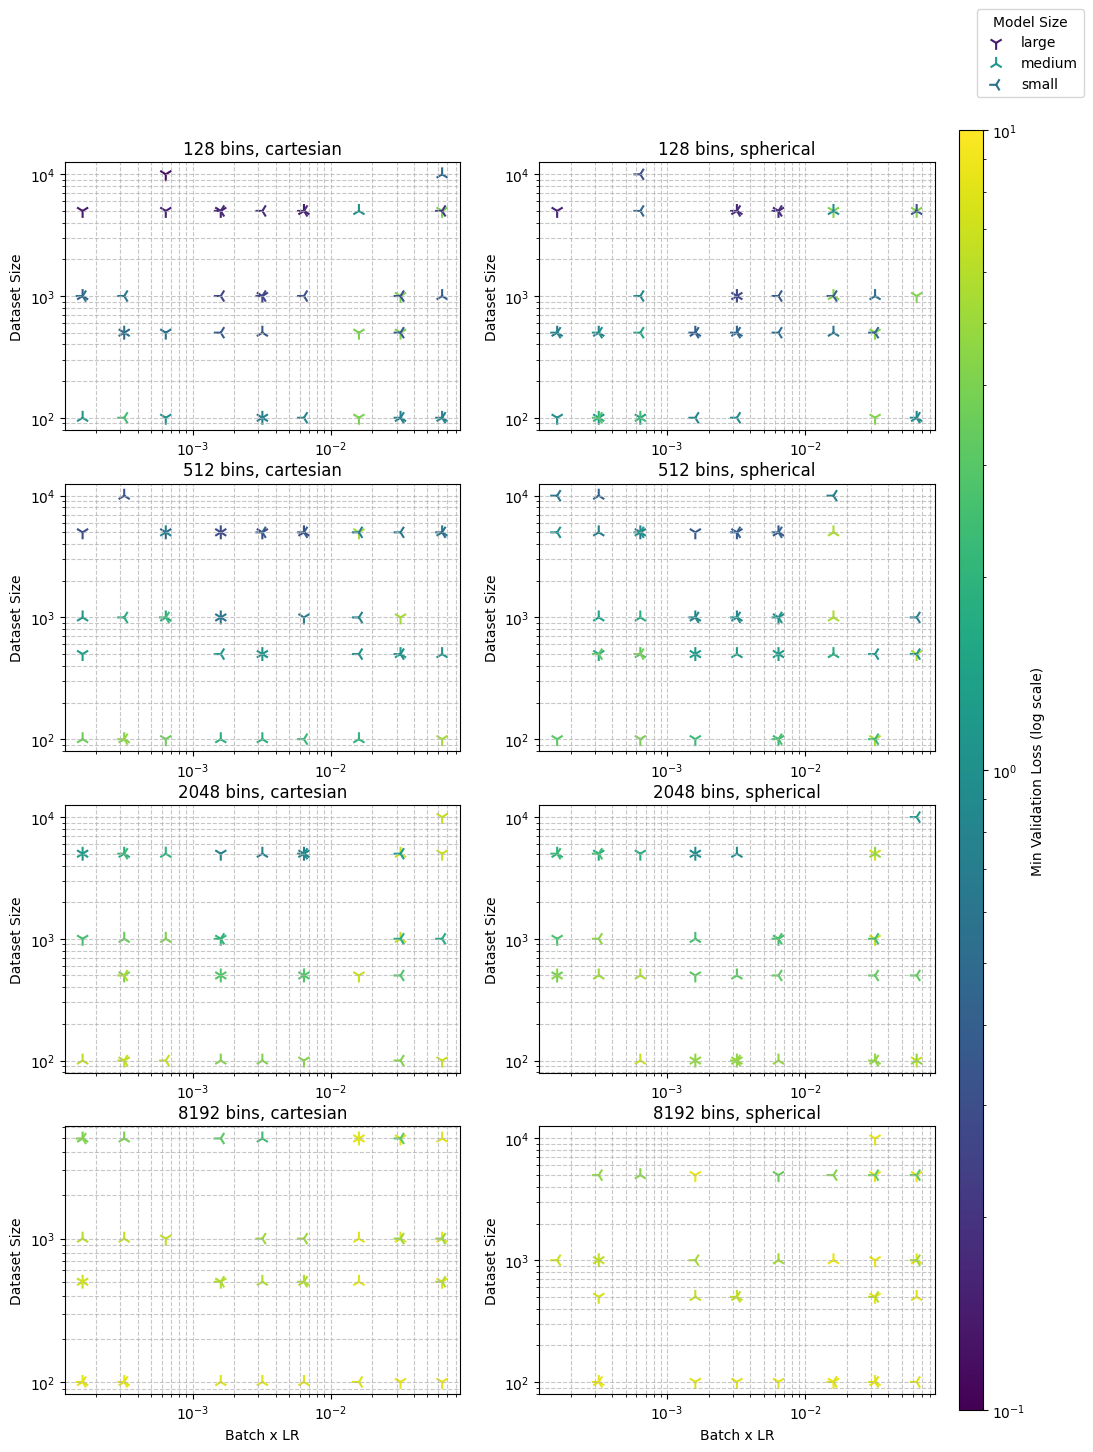

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.ticker as ticker

# Assuming df is your DataFrame
unique_n_bins = sorted(df['n_bins'].unique())
unique_coord_sys = sorted(df['coordinate_system'].unique())

# Ensure there are exactly 4 n_bins and 2 coordinate systems
assert len(unique_n_bins) == 4, "Expected 4 unique n_bins values"
assert len(unique_coord_sys) == 2, "Expected 2 unique coordinate systems"

# Select the run with the lowest min_val_loss for each unique combination
group_cols = ['n_bins', 'coordinate_system', 'batch_times_lr', 'dataset_size', 'legend_label']
best_runs_idx = df.groupby(group_cols)['min_val_loss'].idxmin()
best_runs = df.loc[best_runs_idx]

# Set up the figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(12, 16), squeeze=False)
fig.subplots_adjust(right=0.85)  # Adjust right margin to leave space for colorbar

x_axis = "batch_times_lr"
y_axis = "dataset_size"
color_axis = "min_val_loss"
shape_axis = "legend_label"

# Define shapes for legend_label
# shapes = ["o", "s", "D"]  # Circle, square, diamond
shapes = ["1", "2", "3"]
unique_labels = sorted(best_runs[shape_axis].unique())
shape_axis_to_shape = {label: shapes[i % len(shapes)] for i, label in enumerate(unique_labels)}

# Compute global min and max for consistent color mapping
vmin = 0.1  # or best_runs[color_axis].min()
vmax = 10.0  # or best_runs[color_axis].max()

# Use LogNorm for color mapping
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

for row_idx, n_bins in enumerate(unique_n_bins):
    for col_idx, coord_sys in enumerate(unique_coord_sys):
        ax = axes[row_idx, col_idx]
        
        # Filter runs for this n_bins and coordinate_system
        runs = best_runs[(best_runs['n_bins'] == n_bins) & (best_runs['coordinate_system'] == coord_sys)]
        
        if runs.empty:
            ax.set_visible(False)
            continue
        
        # Group by legend_label to plot points efficiently
        for label, group in runs.groupby(shape_axis):
            scatter = ax.scatter(
                group[x_axis],
                group[y_axis],
                c=group[color_axis],
                marker=shape_axis_to_shape[label],
                s=100,
                label=label,
                cmap='viridis',
                norm=norm
            )
        
        # Set logarithmic scales for axes
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        # Labels and title
        if row_idx == 3:
            ax.set_xlabel("Batch x LR")
        ax.set_ylabel("Dataset Size")
        ax.set_title(f"{n_bins} bins, {coord_sys}")
        ax.grid(True, which="both", ls="--", alpha=0.7)

# Add a single legend to the figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Model Size', bbox_to_anchor=(0.98, 0.98))

# Add a colorbar with manual positioning
cax = fig.add_axes([0.87, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label('Min Validation Loss (log scale)')
cbar.set_ticks([0.1, 1, 10])

plt.show()

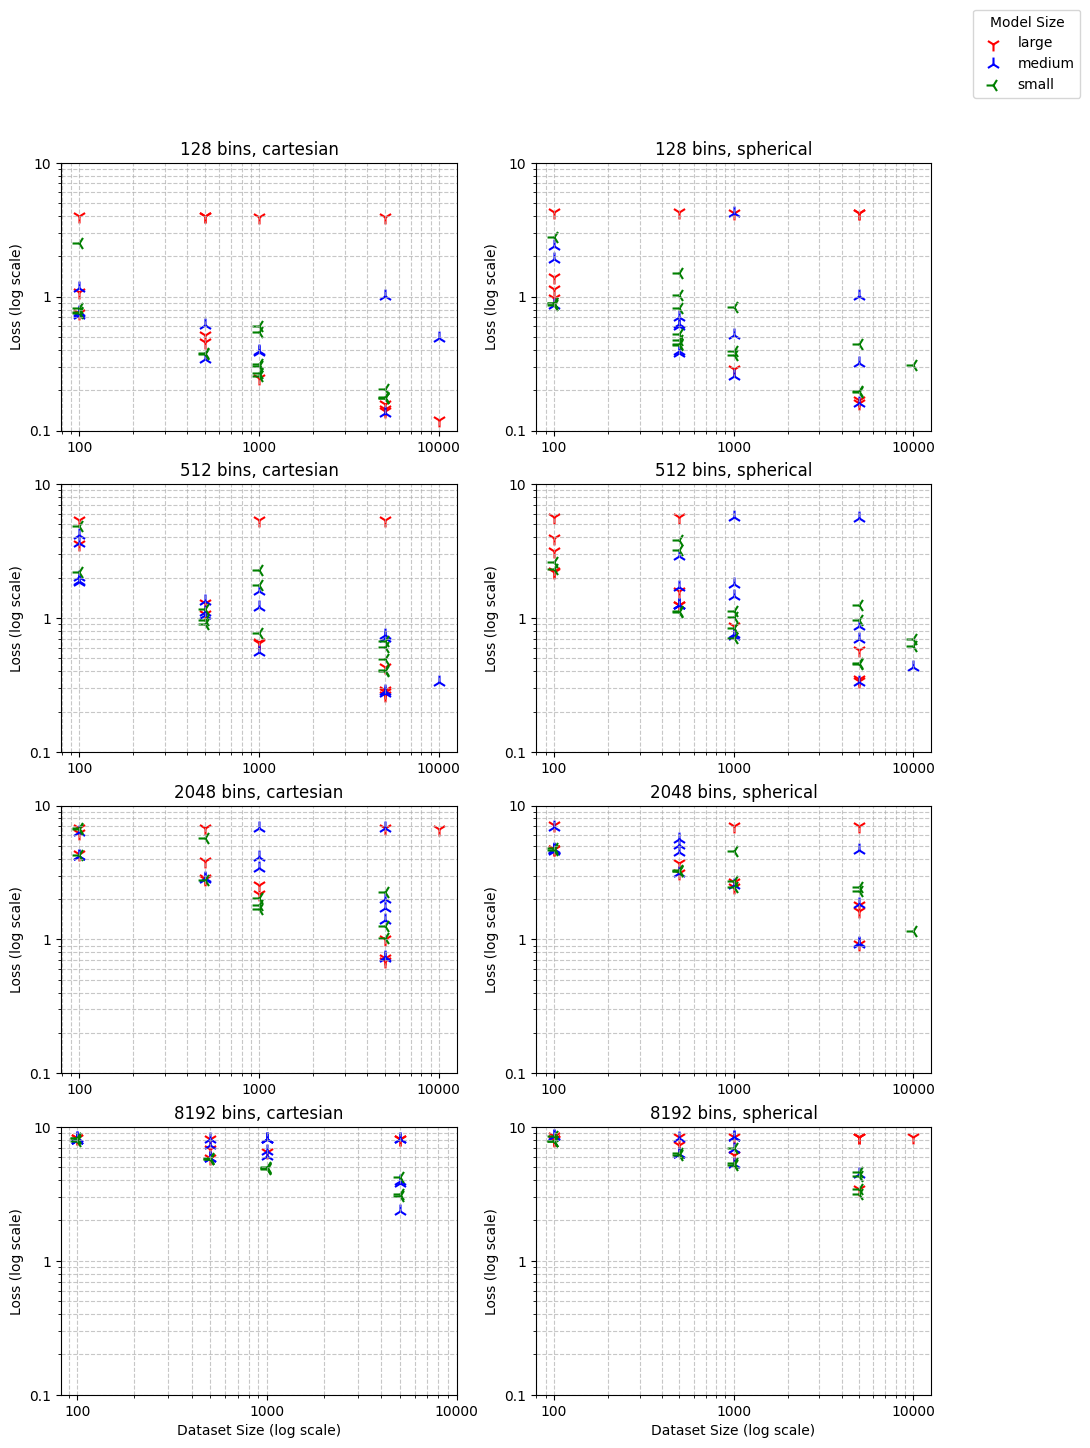

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.ticker as ticker

# Assuming df is your DataFrame
unique_n_bins = sorted(df['n_bins'].unique())
unique_coord_sys = sorted(df['coordinate_system'].unique())

# Ensure there are exactly 4 n_bins and 2 coordinate systems
assert len(unique_n_bins) == 4, "Expected 4 unique n_bins values"
assert len(unique_coord_sys) == 2, "Expected 2 unique coordinate systems"

# Select the run with the lowest min_val_loss for each unique combination
group_cols = ['n_bins', 'coordinate_system', 'batch_times_lr', 'dataset_size', 'legend_label']
best_runs_idx = df.groupby(group_cols)['min_val_loss'].idxmin()
best_runs = df.loc[best_runs_idx]

# Set up the figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(12, 16), squeeze=False)
fig.subplots_adjust(right=0.85)  # Adjust right margin to leave space for colorbar

x_axis = "dataset_size"
y_axis = "min_val_loss"
color_axis = "legend_label"

unique_legend_labels = sorted(best_runs[color_axis].unique())
unique_legend_colors = ['red', 'blue', 'green']
unique_legend_markers = ["1", "2", "3"]

for row_idx, n_bins in enumerate(unique_n_bins):
    for col_idx, coord_sys in enumerate(unique_coord_sys):
        ax = axes[row_idx, col_idx]
        
        # Filter runs for this n_bins and coordinate_system
        runs = best_runs[(best_runs['n_bins'] == n_bins) & (best_runs['coordinate_system'] == coord_sys)]
        
        if runs.empty:
            ax.set_visible(False)
            continue

        for i, label in enumerate(unique_legend_labels):
            runs_to_plot = runs[runs['legend_label'] == label]
            scatter = ax.scatter(
                runs_to_plot[x_axis],
                runs_to_plot[y_axis],
                c=unique_legend_colors[i],
                marker=unique_legend_markers[i],
                s=100,
                label=label,
            )

        # Set logarithmic scales for axes
        ax.set_xscale('log')
        ax.set_yscale('log')

        # ax.set_xlim(1_000, 10_000)
        # ax.set_ylim(0.1, 10)
        ax.set_xticks([100, 1_000, 10_000])
        ax.set_yticks([0.1, 1, 10])
        ax.set_xticklabels([100, 1_000, 10_000])
        ax.set_yticklabels([0.1, 1, 10])

        
        # Labels and title
        if row_idx == 3:
            ax.set_xlabel("Dataset Size (log scale)")
        ax.set_ylabel("Loss (log scale)")
        ax.set_title(f"{n_bins} bins, {coord_sys}")
        ax.grid(True, which="both", ls="--", alpha=0.7)

# Add a single legend to the figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Model Size', bbox_to_anchor=(0.98, 0.98))

plt.show()